In [1]:
from dpt_run import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from solvers.dpt.utils.data import MarkovianOfflineDataset, load_markovian_learning_histories

In [92]:
# dataset = MarkovianOfflineDataset("../GreyBoxDPTOptimizerData/trajectories/Net_d_2_n_4_solvers")
dataset = MarkovianOfflineDataset("../GreyBoxDPTOptimizerData/trajectories/Quadratic_d_1_n_1024")

In [96]:
dataset[0]['actions'], dataset[0]['target_action']

(tensor([ 452,  701,  125,  266,  229,  173,  339,  726,   79,  673,  898,  974,
          548,  713,  798,  498,  499,   91,  856,  238,  874,  836,  253,  784,
           74,  591,  505,  665,  250,  672,  467,  834,  504, 1017,  274,  914,
           72,  637,  120,  723,  565,  327,  875,  630,  414,  992,  937,  790,
          392,  641,  949,  517,  326,  400,  181,    8,   16,  287,  409,  826]),
 tensor(452))

In [97]:
track = []

# for epoch in range(100):
for i, sample in enumerate(dataset):
    track.append(sum(sample['actions'] == sample['target_action']))

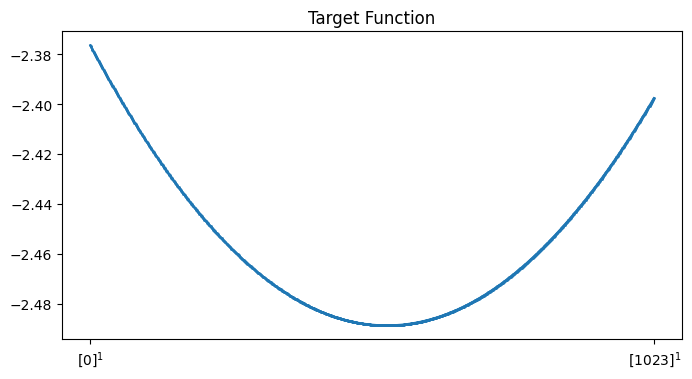

In [57]:
show_problem(problems.Quadratic(d=1, n=1024, seed=np.random.randint(0, 100)))

In [12]:
config = load_config('dpt_run_config.yaml')
dataloaders = get_dataloaders(config)

train_offline_batch = next(iter(dataloaders['train_dataloaders']))
for key, val in train_offline_batch.items():
    print(f'{key:>13} {list(val.shape)}')
print()

val_offline_batch = next(iter(dataloaders['val_dataloaders'][0]))
for key, val in val_offline_batch.items():
    print(f'{key:>13} {list(val.shape)}')

# print()
# val_online_batch = next(iter(dataloaders['val_dataloaders'][1]))
# for key, val in val_online_batch[0].items():
#     try:
#         print(f'{key:>13} {list(val.shape)}')
#     except:
#         pass

train_offline_dataset: 800
val_offline_dataset: 200
  query_state [512, 1]
       states [512, 100, 1]
      actions [512, 100]
  next_states [512, 100, 1]
      rewards [512, 100]
target_action [512]

  query_state [200, 1]
       states [200, 100, 1]
      actions [200, 100]
  next_states [200, 100, 1]
      rewards [200, 100]
target_action [200]


In [13]:
model = DPTSolver(config)
model._offline_step(train_offline_batch, 0)

model.eval()
model._offline_step(val_offline_batch, 0)
# model._online_step(val_online_batch, 0)

{'loss': tensor(5.5448, device='cuda:0', grad_fn=<NllLossBackward0>),
 'accuracy': tensor(0.0050, device='cuda:0')}

In [25]:
# !python dpt_run.py

### DPT Net

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import lightning as L

from solvers.dpt.train import DPTSolver
from problems import Net
from dpt_run import get_online_dataloader, load_config
from utils import print_trajectory

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
# from problems import Net
# from utils import *

# problem = Net(d=4, n=2, seed=0)
# all_actions = get_xaxis(d=problem.d, n=problem.n)
# all_states = problem.target(all_actions)
# print(np.array([all_states.max()]).shape)
# print(np.empty(shape=(1)).shape)

In [ ]:
# logits = torch.randn(size=(1, 10))
# # plt.plot(logits[0])

# for t in (0.01, 0.5, 1.0, 1.5, 2.0, 5.0, 100.0):
#     probs_t = torch.nn.functional.softmax(logits / t, dim=-1)
#     plt.plot(probs_t[0], label=t)

# plt.legend()
# plt.show()

In [3]:
config = load_config('config.yaml')

d = int(np.log2(config["model_params"]["num_actions"]))
problems = [Net(d=d, n=2, seed=i) for i in range(271, 281)]
val_online_dataloader = get_online_dataloader(problems, config)
print('val_online_dataloader:', len(val_online_dataloader.dataset))

val_online_dataloader: 10


In [4]:
checkpoint_file = '../GreyBoxDPTOptimizerData/GreyBoxDPTOptimizer/0cxrd4bf/checkpoints/epoch=299-step=9600.ckpt'
model = DPTSolver.load_from_checkpoint(checkpoint_file).to(device)
model.eval()
print()

In [5]:
def check_temperature(temperature_function):
    visited_points = []
    convergency_step = []

    for _ in range(10):
        for batch in val_online_dataloader:
            for sample in batch:
                result = model.run(
                    **sample,
                    n_steps=config["model_params"]["seq_len"],
                    return_trajectory=True,
                    temperature_function=temperature_function
                )
                right_action_indexes = torch.where(result["actions"] == sample["target_action"])[0]
                if len(right_action_indexes):
                    right_action_step = right_action_indexes[0].item() + 1
                    visited_points_number = len(torch.unique(result["actions"][:right_action_step]))
                else:
                    right_action_step = np.nan
                    visited_points_number = np.nan
                convergency_step.append(right_action_step)
                visited_points.append(visited_points_number)
            # print(model._online_step(batch, 0))
            # break
    mask = np.isnan(convergency_step)
    if mask.all():
        convergency_step = np.nan
        visited_points = np.nan
    else:
        convergency_step = np.nanmean(convergency_step)
        visited_points = np.nanmean(visited_points)
    return convergency_step, visited_points, mask

In [ ]:
temperature_results = {}
temperature_functions = {
   'argmax': lambda x: 0,
    't = 0.00001': lambda x: 0.00001,
    't = 0.5': lambda x: 0.5,
    't = 1.0': lambda x: 1.0, 
    't = 10':  lambda x: 10,
    't = 100': lambda x: 100,
    't ~ 1 - n_step / n_steps': lambda x: 1 - x / config["model_params"]["seq_len"],
    't ~ 10 * (1 - n_step / n_steps)': lambda x: 10 * (1 - x / config["model_params"]["seq_len"]),
    't ~ 100 * (1 - n_step / n_steps)': lambda x: 100 * (1 - x / config["model_params"]["seq_len"]) 
}
for name, temperature_function in temperature_functions.items():
   convergency_step, visited_points, mask = check_temperature(temperature_function)
   temperature_results[name] = dict(
      convergency_step=convergency_step, 
      visited_points=visited_points, 
      mask=mask,
      temperature_function=temperature_function
    ) 

In [ ]:
seq_len = config["model_params"]["seq_len"]
n_step_range = np.arange(0, seq_len)
num_actions = config["model_params"]["num_actions"]

plt.figure(figsize=(10, 4))
for name, result in temperature_results.items():
    print(f'Temperature function: {name}')
    if result['mask'].all():
        print('Has not converged')
    else:
        s_1 = f'Converged at {result["convergency_step"]:.1f}/{seq_len} step'
        s_2 = f' in {np.sum(~result["mask"])}/{len(result["mask"])} cases'
        s_3 = f' and visited {result["visited_points"]:.1f}/{num_actions} points'
        print(s_1 + s_2 + s_3)
    print()
    plt.plot(n_step_range, [result["temperature_function"](n_step) for n_step in n_step_range], label=name)

plt.hlines(0, n_step_range[0], n_step_range[-1])
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
# print_trajectory(result, problems[0])

In [ ]:
# trainer = L.Trainer(
#     precision=config["precision"],
#     enable_model_summary=False
# )
# trainer.test(model, dataloaders=val_online_dataloader)

In [ ]:
# checkpoint = torch.load(checkpoint_file)
# print(checkpoint['hyper_parameters'])

###  DPT Quadratic

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import lightning as L

from solvers.dpt.train import DPTSolver
from dpt_run_2 import *
# from dpt_run import *

from problems import Quadratic, Net
from utils import print_trajectory

device = "cuda" if torch.cuda.is_available() else "cpu"

In [35]:
!python dpt_run_2.py

Seed set to 42
[[0]
 [1]
 [2]
 [3]
 [4]] [[453]
 [453]
 [453]
 [453]
 [453]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[608]
 [608]
 [608]
 [608]
 [608]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[1023]
 [1023]
 [1023]
 [1023]
 [1023]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[449]
 [449]
 [449]
 [449]
 [449]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[0]
 [0]
 [0]
 [0]
 [0]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[703]
 [703]
 [703]
 [703]
 [703]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[0]
 [0]
 [0]
 [0]
 [0]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[582]
 [582]
 [582]
 [582]
 [582]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[0]
 [0]
 [0]
 [0]
 [0]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[1023]
 [1023]
 [1023]
 [1023]
 [1023]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[374]
 [374]
 [374]
 [374]
 [374]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[553]
 [553]
 [553]
 [553]
 [553]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[880]
 [880]
 [880]
 [880]
 [880]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[0]
 [0]
 [0]
 [0]
 [0]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[498]
 [498]
 [498]
 [498]
 [498]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[0]
 [0]
 [0]
 [0]
 [0]]
[[0]
 [1]
 [2]
 [3]
 [4]] [[1023]

In [2]:
%load_ext autoreload
%autoreload 2

In [18]:
from utils import *
from dpt_run_2 import *

config = load_config('config.yaml')

train_offline_dataloader = get_offline_dataloader(config["train_histories_path"], config)
val_offline_dataloader = get_offline_dataloader(config["val_histories_path"], config)
print('train_offline_dataloader:', len(train_offline_dataloader.dataset))
print('val_offline_dataloader:', len(val_offline_dataloader.dataset))

# d = int(np.log2(config["model_params"]["num_actions"]))
# val_online_dataloader_1 = get_online_dataloader([Net(d=d, n=2, seed=i) for i in range(271, 281)], config)
# val_online_dataloader_2 = get_online_dataloader([Net(d=d, n=2, seed=i) for i in range(1, 11)], config)
# print('val_online_dataloader_1:', len(val_online_dataloader_1.dataset))
# print('val_online_dataloader_2:', len(val_online_dataloader_2.dataset))

# logger = WandbLogger(**config["wandb_params"])
# model = DPTSolver(config)

# trainer = L.Trainer(
#     logger=logger,
#     precision=config["precision"],
#     max_epochs=config["max_epochs"],
#     log_every_n_steps=config["log_every_n_steps"],
#     default_root_dir=config["wandb_params"]["save_dir"],
#     enable_model_summary=False
#     # deterministic=True
# )
# trainer.fit(
#     model=model, 
#     train_dataloaders=train_offline_dataloader, 
#     val_dataloaders=[val_offline_dataloader,]
# )

train_offline_dataloader: 1000
val_offline_dataloader: 100


In [19]:
batch = next(iter(train_offline_dataloader))

In [28]:
batch['target_action'].shape

torch.Size([16])